<a href="https://colab.research.google.com/github/kskaran94/VisualSimilarity/blob/master/Triplet_loss_celeb_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
%tensorflow_version 2.x
import pathlib
from PIL import Image
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt
from itertools import permutations
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cp gdrive/My\ Drive/celeb.zip .

In [0]:
%%capture
!unzip celeb.zip -d celeb

In [6]:
!pwd

/content


In [0]:
dataset_path = os.path.join('/content', 'celeb')
train_images_folder = pathlib.Path(os.path.join(dataset_path, 'train'))

train_image_paths = list(train_images_folder.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]

train_full_labels = [pathlib.Path(path).parent.name for path in train_image_paths] #path is str

In [48]:
train_image_paths[:10]

['/content/celeb/train/David_Nalbandian/David_Nalbandian_0012.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0005.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0008.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0001.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0009.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0006.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0002.jpg',
 '/content/celeb/train/David_Nalbandian/David_Nalbandian_0014.jpg',
 '/content/celeb/train/Kim_Clijsters/Kim_Clijsters_0010.jpg',
 '/content/celeb/train/Kim_Clijsters/Kim_Clijsters_0004.jpg']

In [49]:
celeb_names = sorted(item.name for item in train_images_folder.glob('*/') if item.is_dir())
len(celeb_names)

143

In [50]:
label_to_index = dict((name, index) for index, name in enumerate(celeb_names))
label_to_index

{'Abdullah_Gul': 0,
 'Adrien_Brody': 1,
 'Alejandro_Toledo': 2,
 'Alvaro_Uribe': 3,
 'Amelie_Mauresmo': 4,
 'Andre_Agassi': 5,
 'Andy_Roddick': 6,
 'Angelina_Jolie': 7,
 'Ann_Veneman': 8,
 'Anna_Kournikova': 9,
 'Ari_Fleischer': 10,
 'Ariel_Sharon': 11,
 'Arnold_Schwarzenegger': 12,
 'Atal_Bihari_Vajpayee': 13,
 'Bill_Clinton': 14,
 'Bill_Gates': 15,
 'Bill_Simon': 16,
 'Britney_Spears': 17,
 'Carlos_Menem': 18,
 'Carlos_Moya': 19,
 'Catherine_Zeta-Jones': 20,
 'Charles_Moose': 21,
 'Colin_Powell': 22,
 'Condoleezza_Rice': 23,
 'David_Beckham': 24,
 'David_Nalbandian': 25,
 'Dick_Cheney': 26,
 'Dominique_de_Villepin': 27,
 'Donald_Rumsfeld': 28,
 'Edmund_Stoiber': 29,
 'Eduardo_Duhalde': 30,
 'Fidel_Castro': 31,
 'George_HW_Bush': 32,
 'George_Robertson': 33,
 'George_W_Bush': 34,
 'Gerhard_Schroeder': 35,
 'Gloria_Macapagal_Arroyo': 36,
 'Gonzalo_Sanchez_de_Lozada': 37,
 'Gordon_Brown': 38,
 'Gray_Davis': 39,
 'Guillermo_Coria': 40,
 'Halle_Berry': 41,
 'Hamid_Karzai': 42,
 'Hans_Blix

In [51]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths] #path is str

print("First 10 labels indices: ", all_labels[:10])
print("Length of all labels: ", len(all_labels))

First 10 labels indices:  [25, 25, 25, 25, 25, 25, 25, 25, 81, 81]
Length of all labels:  1144


In [0]:
X_flat = train_image_paths
y = all_labels

In [53]:
print(len(X_flat))

1144


/content/celeb/train/David_Nalbandian/David_Nalbandian_0012.jpg


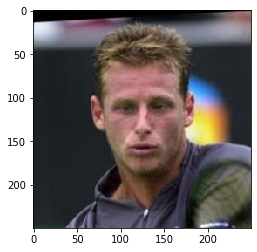

/content/celeb/train/David_Nalbandian/David_Nalbandian_0005.jpg


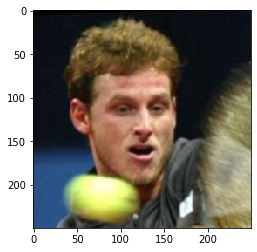

/content/celeb/train/David_Nalbandian/David_Nalbandian_0008.jpg


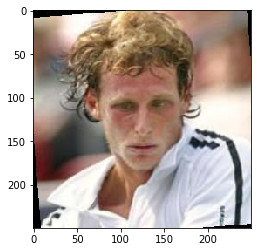

/content/celeb/train/David_Nalbandian/David_Nalbandian_0001.jpg


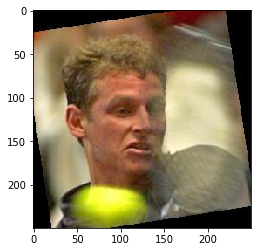

/content/celeb/train/David_Nalbandian/David_Nalbandian_0009.jpg


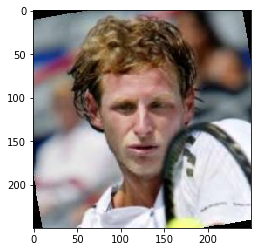

In [54]:
for img in train_image_paths[:5]:
  print(img)
  pil_im = Image.open(img)
  im_array = np.asarray(pil_im)
  plt.imshow(im_array)
  plt.show()

In [55]:
im_array.shape

(250, 250, 3)

In [0]:
IMAGE_HEIGHT = 250
IMAGE_WIDTH = 250
NUM_CHANNEL = 3

In [0]:
def generate_triplet(x,y,testsize=0.2, ap_pairs=10, an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    # triplet_train_pairs = []
    # triplet_test_pairs = []
    anchor_train, anchor_test =[], []
    positive_train, positive_test =[], []
    negative_train, negative_test =[], []

    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = plt.imread(data_xy[0][ap[0]])
            Positive = plt.imread(data_xy[0][ap[1]])
            for n in Neg_idx:
                Negative = plt.imread(data_xy[0][n])
                anchor_train.append(Anchor)
                positive_train.append(Positive)
                negative_train.append(Negative)
                # triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = plt.imread(data_xy[0][ap[0]])
            Positive = plt.imread(data_xy[0][ap[1]])
            for n in Neg_idx:
                Negative = plt.imread(data_xy[0][n])
                anchor_test.append(Anchor)
                positive_test.append(Positive)
                negative_test.append(Negative)
                # triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(anchor_train), np.array(anchor_test), np.array(positive_train), np.array(positive_test), np.array(negative_train), np.array(negative_test)

anchor_train, anchor_test, positive_train, positive_test, negative_train, negative_test = generate_triplet(X_flat, np.array(y), ap_pairs=5, an_pairs=5, testsize=0.2)

In [58]:
anchor_train.shape

(2860, 250, 250, 3)

In [59]:
anchor_test.shape

(715, 250, 250, 3)

In [0]:
# defining triplet loss
def triplet_loss(y_true, y_pred, alpha = 0.4):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:
#from keras.applications.resnet50 import ResNet50

def create_base_network(in_dims):
    """
    Base network to be shared.
    """

    base_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    # base_model.trainable = False 

    x = base_model.output
    x = Flatten(name='flatten')(x)
    predictions = Dense(100)(x)
                                                                                                                               
    model = Model(inputs=base_model.input, outputs=predictions)
    print(len(model.layers))

    for layer in model.layers[0:141]:
        layer.trainable = False
                         
    return model



In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [67]:
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNEL,)

anchor_input = Input(IMG_SIZE, name='anchor_input')
positive_input = Input(IMG_SIZE, name='positive_input')
negative_input = Input(IMG_SIZE, name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network(IMG_SIZE)

encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

model.summary()

177
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 100)          36695012    anchor_input[0][0]               
                                                                 positive_input[0][0]   

In [0]:
label_train = np.empty((anchor_train.shape[0],1))
label_test = np.empty((anchor_test.shape[0],1))

In [69]:
label_train.shape

(2860, 1)

In [70]:
#Y_dummy = np.empty((Anchor.shape[0],300))
model.fit(x=[anchor_train,positive_train,negative_train],
          y=np.array(label_train),
          validation_data=([anchor_test, positive_test, negative_test], np.array(label_test)),
          batch_size=64,
          epochs=3)

Train on 2860 samples, validate on 715 samples
Epoch 1/3
2860/2860 [==============================] - 122s 43ms/sample - loss: 255.6825 - val_loss: 354.1802
Epoch 2/3
2860/2860 [==============================] - 112s 39ms/sample - loss: 33.2721 - val_loss: 160.6245
Epoch 3/3
2860/2860 [==============================] - 112s 39ms/sample - loss: 10.4133 - val_loss: 125.1297


In [0]:
model.save_weights('resnet_triplet_model_celeb.hdf5')

# Evaluation on test set

In [72]:
test_images_folder = pathlib.Path(dataset_path+'/test')
print(test_images_folder)

/content/celeb/test


In [0]:
test_image_paths = list(test_images_folder.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths]

In [74]:
print(len(test_image_paths))

286


In [75]:
test_image_paths[:10]

['/content/celeb/test/David_Nalbandian/David_Nalbandian_0007.jpg',
 '/content/celeb/test/David_Nalbandian/David_Nalbandian_0003.jpg',
 '/content/celeb/test/Kim_Clijsters/Kim_Clijsters_0002.jpg',
 '/content/celeb/test/Kim_Clijsters/Kim_Clijsters_0007.jpg',
 '/content/celeb/test/Jackie_Chan/Jackie_Chan_0001.jpg',
 '/content/celeb/test/Jackie_Chan/Jackie_Chan_0002.jpg',
 '/content/celeb/test/Jiang_Zemin/Jiang_Zemin_0006.jpg',
 '/content/celeb/test/Jiang_Zemin/Jiang_Zemin_0017.jpg',
 '/content/celeb/test/Wen_Jiabao/Wen_Jiabao_0008.jpg',
 '/content/celeb/test/Wen_Jiabao/Wen_Jiabao_0009.jpg']

In [0]:
test_labels = [pathlib.Path(path).parent.name for path in test_image_paths]

In [0]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)
trained_model.load_weights('resnet_triplet_model_celeb.hdf5')

In [0]:
def read_image(image_path):
  return plt.imread(image_path)

In [0]:
train_images = list(map(read_image, train_image_paths))
test_images = list(map(read_image, test_image_paths))

In [0]:
train_images = np.array(train_images)
test_images = np.array(test_images)

In [81]:
train_images.shape

(1144, 250, 250, 3)

In [82]:
test_images.shape

(286, 250, 250, 3)

In [0]:
def get_embeddings(images):
  feature_list = trained_model.predict(images)
  return feature_list

In [0]:
train_embeddings = get_embeddings(train_images)

In [85]:
train_embeddings.shape

(1144, 100)

In [0]:
test_embeddings = get_embeddings(test_images)

In [87]:
test_embeddings.shape

(286, 100)

In [0]:
import IPython.display as display
correct_identified = 0

for index, test_img_embedding in enumerate(test_embeddings):
  diff = (train_embeddings - test_img_embedding)**2
  dist = np.sum(diff, axis=1)
  # print(dist)
  nearest_neighbors = np.argsort(dist)[:10]
  
  if test_labels[index] in np.array(train_full_labels)[nearest_neighbors[:10]]:
    #print(test_labels[index], train_full_labels[nearest_neighbors[0]])
    correct_identified += 1


In [89]:
print("Accuracy is ", correct_identified / test_embeddings.shape[0])


Accuracy is  0.5909090909090909
